In [1]:
import os
execfile(os.path.join(os.environ["SPARK_HOME"], 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.3.1
      /_/

Using Python version 2.7.10 (default, Feb  7 2017 00:08:15)
SparkSession available as 'spark'.


In [2]:
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import explode
from pyspark.sql import Window
import pyspark.sql.functions as f

In [26]:
import numpy as np
import pandas as pd
import seaborn as sn
sn.set_style("darkgrid")

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn.preprocessing import scale

In [4]:
jsonData = spark.read.json("hdfs:///jason/beer")

In [ ]:
jsonData.printSchema()

Top Beer Brands by Social Media Presence

In [7]:
brands = jsonData.select('user.name', 'user.followers_count', 'user.verified', 'user.url', 'user.description', 'user.favourites_count')
brands.createOrReplaceTempView("brands")
brandsDF = spark.sql("SELECT brands.name, brands.followers_count, brands.description, brands.favourites_count FROM brands where brands.url != 'null' and verified = true")
brandsDF = brandsDF.filter(brandsDF.description.contains('21+') | brandsDF.name.contains('Brew'))
brandcounts = brandsDF.groupBy('name').count()
brands = brandsDF.dropDuplicates(['name']).drop('description')
Brands = brandcounts.join(brands, on='name')
Brands.show(50)

+--------------------+-----+---------------+----------------+
|                name|count|followers_count|favourites_count|
+--------------------+-----+---------------+----------------+
|             BrewDog|    3|         125732|           26156|
|  Brooklyn Brew Shop|    3|           9815|            6229|
|      Michelob ULTRA|    1|          57886|             292|
|Wild Rose Brewery...|    1|          17530|            5544|
|        Simon Brewer|    1|          22577|            5829|
|     MadTree Brewing|    2|          19292|           13337|
|  SweetWater Brewery|    1|          70929|            7107|
|  Ballast Point Beer|    2|          94783|           10706|
|  Blue Point Brewery|    1|          22078|           12347|
|    3 Floyds Brewpub|    1|          25476|             116|
|      Loddon Brewery|    1|           7053|            3649|
|          HonestBrew|    1|          13911|            7967|
|      Anchor Brewing|    2|          66906|           14654|
| Night 

In [21]:
brands = Brands.toPandas()

In [22]:
brands.head()

,name,count,followers_count,favourites_count
0,BrewDog,3,125732,26156
1,Brooklyn Brew Shop,3,9815,6229
2,Michelob ULTRA,1,57886,292
3,Wild Rose Brewery Ltd,1,17530,5544
4,Simon Brewer,1,22577,5829


In [ ]:
brands = brands.set_index('name')

In [56]:
brands['score'] = scale(brands['count']) + scale(brands['followers_count']) + scale(brands['favourites_count'])
brands.sort_values('score', ascending=False).head(10)

,count,followers_count,favourites_count,score
name,,,,
Brew Studs,12,100773,51421,10.137127
Dogfish Head Brewery,2,298979,19915,4.962605
Harpoon Brewery,2,69830,47482,3.426856
BrewDog,3,125732,26156,3.101009
Goose Island Beer Co,2,79502,35414,2.533159
New Belgium Brewing,1,244809,8532,2.443199
Deschutes Brewery,1,114047,30392,2.105596
Budweiser,2,162713,2934,1.115722
Allagash Brewing Co,1,32629,33973,1.013739


In [63]:
TopBrands = brands.query('score > 1').reset_index().sort_values('score', ascending=False)

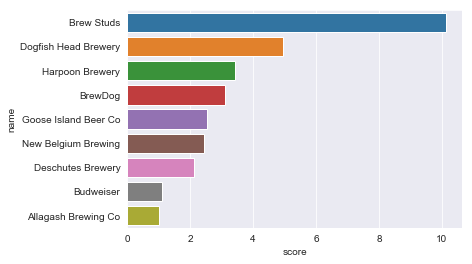

In [64]:
sn.barplot(x='score', y='name', data=TopBrands)

Brand Mentions

In [11]:
mentions = jsonData.select(explode("entities.user_mentions").alias("mentions")).\
select("mentions.name")
mentions = mentions.dropna()
MentionCounts = mentions.groupBy('name').count()
BrandsTrim = Brands.select('name')
BrMentions = BrandsTrim.join(MentionCounts, on='name')
BrMentions.show(50)

+--------------------+-----+
|                name|count|
+--------------------+-----+
|             BrewDog|  144|
|  Brooklyn Brew Shop|    2|
|      Michelob ULTRA|   65|
|Wild Rose Brewery...|    9|
|     MadTree Brewing|   23|
|  SweetWater Brewery|   31|
|  Ballast Point Beer|   46|
|    3 Floyds Brewpub|    1|
|  Blue Point Brewery|   12|
|      Loddon Brewery|    4|
|          HonestBrew|    2|
|      Anchor Brewing|   20|
| Night Shift Brewing|   17|
|          Brew Studs|   55|
|Blue Moon Brewing Co|   20|
|   10 Barrel Brewing|   24|
|Goose Island Beer Co|  161|
|Lancaster Brewing Co|    4|
|      Summit Brewing|   23|
|           Budweiser|   65|
|    3 Floyds Brewing|   48|
|   Yards Brewing Co.|    9|
| New Belgium Brewing|  101|
|               RITAS|   10|
|Pike Brewing Company|    8|
| Lift Bridge Brewing|    7|
|         MillerCoors|   74|
|      Lone Star Beer|   15|
|     Harpoon Brewery|   50|
|   Deschutes Brewery|   57|
|     Short's Brewing|   33|
|        Tropi

In [57]:
Mentions = BrMentions.toPandas()

In [59]:
Mentions = Mentions.sort_values('count', ascending=False)
Mentions.head(10)

,name,count
16,Goose Island Beer Co,161
0,BrewDog,144
35,Dogfish Head Brewery,138
22,New Belgium Brewing,101
26,MillerCoors,74
2,Michelob ULTRA,65
19,Budweiser,65
29,Deschutes Brewery,57
13,Brew Studs,55
28,Harpoon Brewery,50


In [60]:
Mentions.tail(10)

,name,count
39,Big Rock Brewery,5
41,Meantime Brewing Co.,5
17,Lancaster Brewing Co,4
9,Loddon Brewery,4
36,Maestro Dobel,3
40,Guinness US,3
1,Brooklyn Brew Shop,2
10,HonestBrew,2
7,3 Floyds Brewpub,1
31,Tropicana AC,1


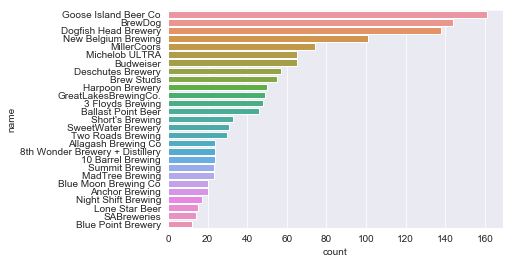

In [62]:
Mentions = Mentions.query('count > 10')
sn.barplot(x='count', y='name', data=Mentions)

Top Beer Brands by Locality

In [14]:
places = jsonData.select("place", explode("entities.user_mentions").alias("mentions")).\
select("mentions.name", "place.country")
places = places.dropna().groupBy('name', 'country').count()
BrandsTrim2 = Brands.drop('count')
Locality = places.join(BrandsTrim2, on='name')
Locality.sort(f.desc('country')).show(50)

+--------------------+------------------+-----+---------------+----------------+
|                name|           country|count|followers_count|favourites_count|
+--------------------+------------------+-----+---------------+----------------+
|  SweetWater Brewery|     United States|   10|          70929|            7107|
|  Ballast Point Beer|     United States|   10|          94783|           10706|
|             BrewDog|     United States|    3|         125732|           26156|
|      Michelob ULTRA|     United States|    2|          57886|             292|
|     MadTree Brewing|     United States|    7|          19292|           13337|
|Lancaster Brewing Co|     United States|    1|           9485|            9698|
|      Summit Brewing|     United States|    1|          52433|            9786|
|    3 Floyds Brewing|     United States|   11|          88231|            3498|
|   Yards Brewing Co.|     United States|    3|          22508|           24356|
|  Blue Point Brewery|     U

In [100]:
locality = Locality.toPandas()

In [101]:
locality = locality.sort_values(['country', 'count'], ascending=False)
locality.head(10)

,name,country,count,followers_count,favourites_count
22,Goose Island Beer Co,United States,46,79502,35414
38,Dogfish Head Brewery,United States,34,298979,19915
29,New Belgium Brewing,United States,21,244809,8532
32,MillerCoors,United States,16,26413,6476
45,GreatLakesBrewingCo.,United States,15,52224,8554
36,Deschutes Brewery,United States,14,114047,30392
21,10 Barrel Brewing,United States,12,18696,20050
34,Harpoon Brewery,United States,12,69830,47482
27,3 Floyds Brewing,United States,11,88231,3498
11,SweetWater Brewery,United States,10,70929,7107


In [102]:
locality

,name,country,count,followers_count,favourites_count
22,Goose Island Beer Co,United States,46,79502,35414
38,Dogfish Head Brewery,United States,34,298979,19915
29,New Belgium Brewing,United States,21,244809,8532
32,MillerCoors,United States,16,26413,6476
45,GreatLakesBrewingCo.,United States,15,52224,8554
36,Deschutes Brewery,United States,14,114047,30392
21,10 Barrel Brewing,United States,12,18696,20050
34,Harpoon Brewery,United States,12,69830,47482
27,3 Floyds Brewing,United States,11,88231,3498
11,SweetWater Brewery,United States,10,70929,7107


In [103]:
US = locality.query("country == 'United States'")
US = US.sort_values('count', ascending=False)

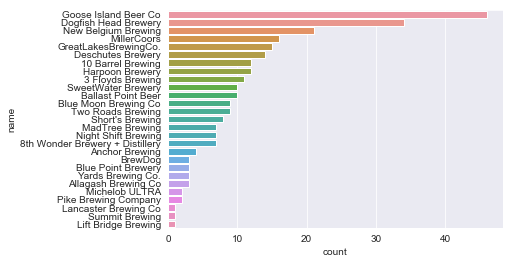

In [104]:
sn.barplot(x='count', y='name', data=US)

In [106]:
EA = locality.query("country != 'United States' & country != ''")
EA = EA.sort_values('count', ascending=False)
EA

,name,country,count,followers_count,favourites_count
3,BrewDog,United Kingdom,15,125732,26156
23,Goose Island Beer Co,Brasil,5,79502,35414
24,Goose Island Beer Co,United Kingdom,5,79502,35414
43,Meantime Brewing Co.,United Kingdom,2,33567,16697
7,BrewDog,Nederland,2,125732,26156
2,BrewDog,Italia,2,125732,26156
4,BrewDog,Denmark,1,125732,26156
1,BrewDog,Brazil,1,125732,26156
42,Big Rock Brewery,Canada,1,21744,17378
19,Blue Moon Brewing Co,Canada,1,52712,9631


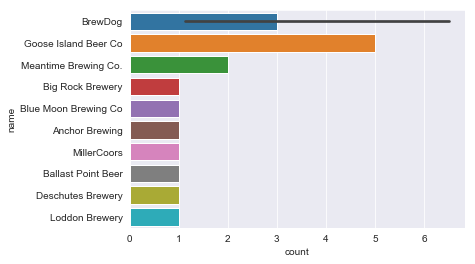

In [107]:
sn.barplot(x='count', y='name', data=EA)